In [2]:
import import_ipynb
from imutils import paths
import matplotlib.pyplot as plt
from skimage import feature
import numpy as np
import cv2
import os
import glob

**Loading the cleaned dataset**

In [3]:
# Loading clean faces dataset
def chargerFaces(inputPath):
    imagePaths = list(paths.list_images(inputPath))
    names = [p.split(os.path.sep)[-1] for p in imagePaths]
    (names , counts) = np.unique(names , return_counts = True)
    names = names.tolist()

    faces = []
    labels = []
    
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        name = imagePath.split(os.path.sep)[-1]
        
        faces.append(image)
        labels.append(name.split(" ")[0])
    
    faces = np.array(faces)
    labels = np.array(labels)
    
    return (faces , labels)   

In [4]:
faces, labels = chargerFaces('FacesDB')

In [5]:
print(type(faces))
print(faces.shape)
print(len(faces))
print(faces[0].shape)

<class 'numpy.ndarray'>
(269, 100, 100, 3)
269
(100, 100, 3)


Aguerd


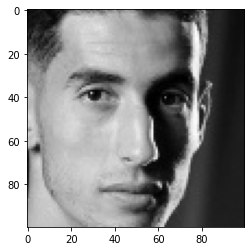

In [6]:
plt.imshow(faces[0], cmap='gray')
print(labels[0])

### Model

In [7]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import imutils
import time
import cv2
import os

In [8]:
# Convert faces into grayscale
def convertToGray(images):
    faces = []
    for i in range(len(images)):
        img = cv2.cvtColor(images[i] , cv2.COLOR_BGR2GRAY)
        faces.append(img)
    faces = np.array(faces)
    return faces      

In [9]:
faces = convertToGray(faces)

In [10]:
print(type(faces))
print(faces.shape)
print(len(faces))
print(faces[0].shape)

<class 'numpy.ndarray'>
(269, 100, 100)
269
(100, 100)


In [119]:
X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = 0.20,
                                                          stratify = labels , random_state = 42)

In [128]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(122, 100, 100)
(122,)
(31, 100, 100)
(31,)


In [178]:
b = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[1])
b.shape

(122, 10000)

**LBPH Face recognizer model**

In [135]:
def cross_validation(faces, labels, cv = 5 , test_size = 0.25 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
    
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of random_states

  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state, shuffle= True)
    
    # define and train the LBP model
    recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)

    recognizer.train(X_train , y_train)

    # initialize our predictions and confidence lists
    predictions = []
    confidence = []

    # loop over the test data
    for i in range(0 , len(X_test)):
      # classify the face and update the predictions
      # and confidence scores
      (prediction , conf) = recognizer.predict(X_test[i])
      predictions.append(prediction)
      confidence.append(confidence)

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = True)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("Predictions\\face-{}.png".format(i))
     
  # save the model
  if save_model:
    # save the model 
    recognizer.save("face-recognizer-model.yml")

  return f1_scores

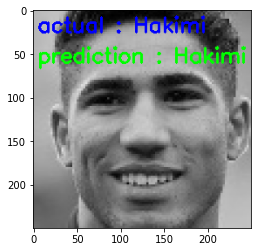

In [136]:
f1_scores = cross_validation(faces, labels, cv=5 , save_model=True)

In [137]:
f1_scores.mean()

0.47690448

**KNN Model**

In [11]:
def cross_validation_KNN(faces, labels, cv = 5 , test_size = 0.25 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
    
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of random_states

  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state,shuffle= True)
    
    # define and train the LBP model
    knn = KNeighborsClassifier(n_neighbors=100)

    knn.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[1]), y_train)

    # Make predictions
    predictions = knn.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[1]))
      

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  if output:
    # generate a sample of testing data
    #idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = True)

    for i in range(len(X_test)):
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("Predictions_KNN\\face-{}.png".format(i))
     
  # save the model
  #if save_model:
    # save the model 
    #knn.save("KNN-model.yml")

  return f1_scores

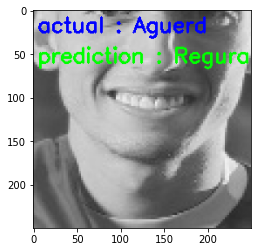

In [12]:
f1_scores_KNN = cross_validation_KNN(faces, labels, cv=7 , save_model=True)

In [13]:
f1_scores_KNN.mean()

0.19436137

**Ensemble Learning**

In [216]:
def cross_validation_Ensemble(faces, labels, cv = 5 , test_size = 0.25 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
    
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of random_states

  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state, shuffle= True)
    
    # define and train the LBP model
    clf = RandomForestClassifier()

    clf.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[1]), y_train)

    # Make predictions
    predictions = clf.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[1]))
      

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  if output:
    # generate a sample of testing data
    #idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = True)

    for i in range(len(X_test)):
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("Predictions_Ensemble\\face-{}.png".format(i))
     
  # save the model
  #if save_model:
    # save the model 
    #knn.save("KNN-model.yml")

  return f1_scores

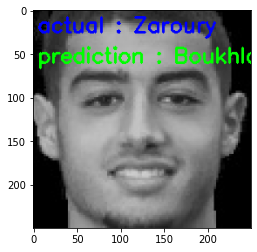

In [217]:
f1_scores_Ensemble = cross_validation_Ensemble(faces, labels, cv=7 , save_model=True)

In [218]:
f1_scores_Ensemble.mean()

0.39581618

**Neural Network with LBP**

**Feature Extraction**

In [11]:
class LocalBinaryPatterns:
    def __init__(self , numPoints , radius):
        self.numPoints = numPoints
        self.radius = radius

    def describe(self , image , eps=1e-7):
        lbp = feature.local_binary_pattern(image , self.numPoints , self.radius)
        hist = plt.hist(lbp.ravel())
        return lbp , hist

In [12]:
def LBPFace(image):
    img = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    lbp , hist = desc.describe(img)
    return lbp , hist

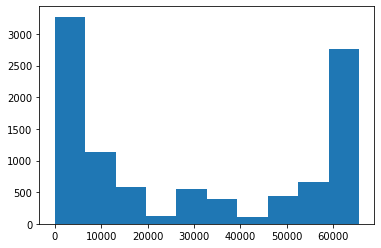

In [13]:
desc = LocalBinaryPatterns(16, 5)
lbp, hist = LBPFace(faces[0])

Aguerd


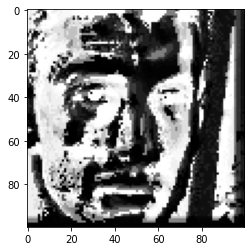

In [14]:
plt.imshow(lbp, cmap='gray')
print(labels[0])

In [19]:
def LBPFaceList(Faces):
    lbpList = []
    for i in range(len(Faces)):
        lbp, _ = LBPFace(Faces[i])
        lbpList.append(lbp)
    lbpList = np.array(lbpList)
    return lbpList

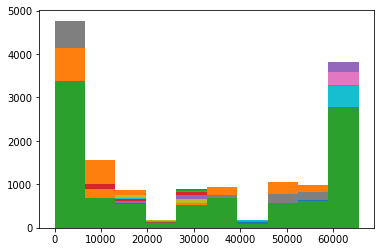

In [20]:
lbpList = LBPFaceList(faces)

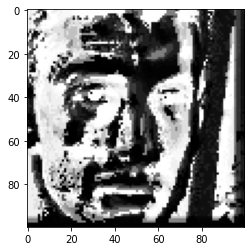

In [21]:
plt.imshow(lbpList[0], cmap='gray')

In [22]:
import keras

In [36]:
# encode the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# split the data into training and test set
X_train , X_test , y_train , y_test = train_test_split(lbpList , labels , test_size = 0.25,
                                                      stratify = labels , random_state = 42, shuffle= True)
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255

x_train_flattened = X_train.reshape(len(X_train), 100*100)
x_test_flattened = X_test.reshape(len(X_test), 100*100)
    
# define and train the LBP model
model=keras.Sequential([
    keras.layers.Dense(120,input_shape=(10000,),activation='sigmoid'),
    keras.layers.Dense(10,activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.fit(x_train_flattened,y_train,epochs=10)

# Make predictions
testPredictions = model.evaluate(x_test_flattened,y_test)
trainPredictions = model.evaluate(x_train_flattened,y_train) 
print("Test score : " + str(testPredictions))
print("Train score : " + str(trainPredictions))

Epoch 1/10
4/4 [==============================] - 1s 14ms/step - loss: 2.4438 - accuracy: 0.0965
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 2.1608 - accuracy: 0.1140
Epoch 3/10
4/4 [==============================] - 0s 13ms/step - loss: 2.1117 - accuracy: 0.1140
Epoch 4/10
4/4 [==============================] - 0s 14ms/step - loss: 2.0927 - accuracy: 0.1667
Epoch 5/10
4/4 [==============================] - 0s 15ms/step - loss: 2.0744 - accuracy: 0.1754
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 2.0708 - accuracy: 0.1842
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 2.0693 - accuracy: 0.1316
Epoch 8/10
4/4 [==============================] - 0s 15ms/step - loss: 2.0672 - accuracy: 0.1579
Epoch 9/10
4/4 [==============================] - 0s 17ms/step - loss: 2.0646 - accuracy: 0.1842
Epoch 10/10
4/4 [==============================] - 0s 7ms/step - loss: 2.0591 - accuracy: 0.1754
Test score : [2.06001782417297